# Plotting with S3

In [1]:
from plotting_utils import (
    plot_forecast,
    plot_crps_bydate,
    score_improvement_bysite,
    plot_improvement_bysite,
    plot_global_percentages,
    plot_region_percentages,
    plot_site_type_percentages_bymodel,
    plot_site_type_percentages_global,
    plot_window_and_sitetype_performance,
    generate_metadata_df,
    plot_crps_over_time_agg,
)
import pandas as pd
from utils import establish_s3_connection
import warnings

# Ignore all warnings; admittedly not the best practice here :/
warnings.filterwarnings("ignore")

targets = pd.read_csv("targets.csv.gz")
metadata = generate_metadata_df()

/home/rstudio/.virtualenv/neon4cast-darts/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/rstudio/.virtualenv/neon4cast-darts/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
s3_client = establish_s3_connection(
    endpoint='https://minio.carlboettiger.info',
    json_file='credentials.json',
) 


 Using https://minio.carlboettiger.info for data storage and access.


In [ ]:
model_names = ["BlockRNN", "Transformer", "NBEATS", "TCN", "RNN", "TFT"]
target_variables = ["oxygen"]
ids = [0, 1, 2, 3, 4]
s3_dict = {'client': s3_client, 'bucket': 'shared-neon4cast-darts'}
scores_dict = {}
for model in model_names:
    scores_dict[model] = {}
    for id_ in ids:
        scores_dict[model][id_] = {}
        for target_variable in target_variables:
            inter_merged, intra_merged = score_improvement_bysite(
                model,
                id_,
                targets, 
                target_variable, 
                s3_dict=s3_dict,
            )
            scores_dict[model][id_][target_variable] = {}
            scores_dict[model][id_][target_variable]['inter'] = inter_merged
            scores_dict[model][id_][target_variable]['intra'] = intra_merged

In [ ]:
global_dfs = {}
for target_variable in target_variables:
    global_dfs[target_variable] = {}
    for pos in ['inter', 'intra']:
        global_dfs[target_variable][pos] = pd.concat(
            [scores_dict[model][id_][target_variable][pos] for model in model_names for id_ in ids]
        )

Doing this just as a way to check that other code is working appropriately.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_global_percentages_by_id(df_, title_name, historical=True):
    '''
    Returns a plot of the scoring metric difference vs. ML model type
    '''
    plt.figure(figsize=(12, 8))
    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 

    sns.boxplot(
        data=df_,
        x='model_id',
        y=column,
        showfliers=False,
        color='tab:blue'
    )

    plt.grid(False)
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.legend(labels=[])
    plt.title(title_name)

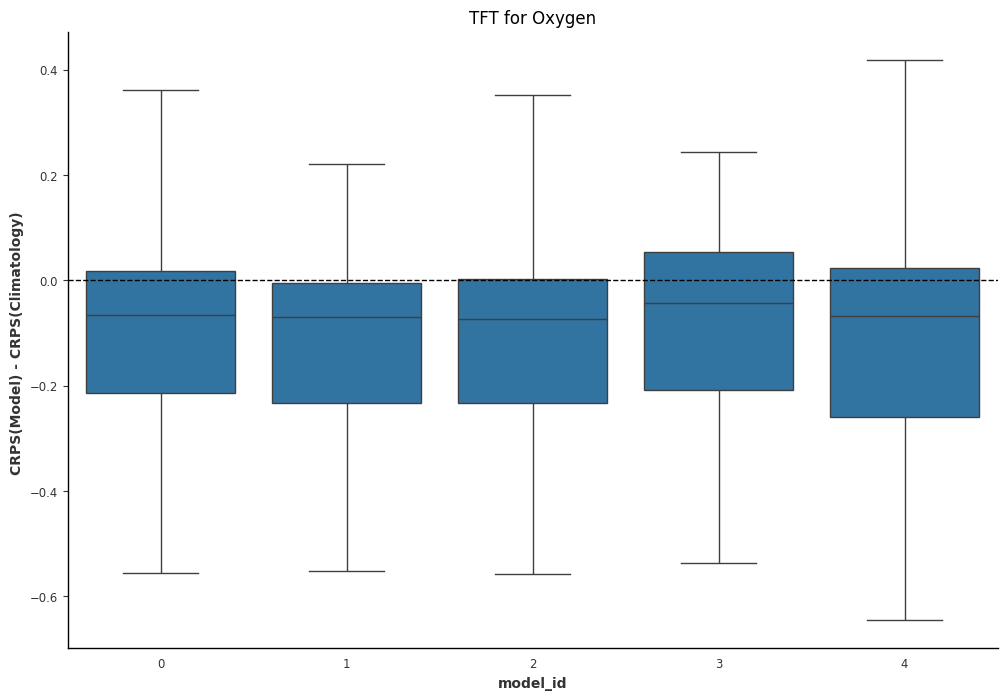

In [55]:
model = 'TFT'
_df = global_dfs['oxygen']['inter'] 
df_of_intererst = _df[_df['model'] == model]
plot_global_percentages_by_id(df_of_intererst, f'{model} for Oxygen')

Now trying to find the best id, and putting together dataframes with these best models

In [28]:
def return_best_id(df):
    medians = df.groupby('model_id')['difference_historical_ml_crps'].median()
    lowest_median_id = medians.idxmin()

    return(lowest_median_id)

In [29]:
best_models = {}
for model in model_names:
    best_models[model] = {}
    for target_variable in target_variables:
        # Need to do the following but also filter for model type
        df_ = global_dfs[target_variable]['inter']
        df = df_[df_['model'] == model]
        best_models[model][target_variable] = return_best_id(df)

In [39]:
best_performers_dfs = {}
for target_variable in target_variables:
    best_performers_dfs[target_variable] = {}
    for pos in ['inter', 'intra']:
        best_performers_dfs[target_variable][pos] = {}
        best_performers_dfs[target_variable][pos] = pd.concat(
            [scores_dict[model][best_models[model][target_variable]]
             [target_variable][pos] for model in model_names]
        )

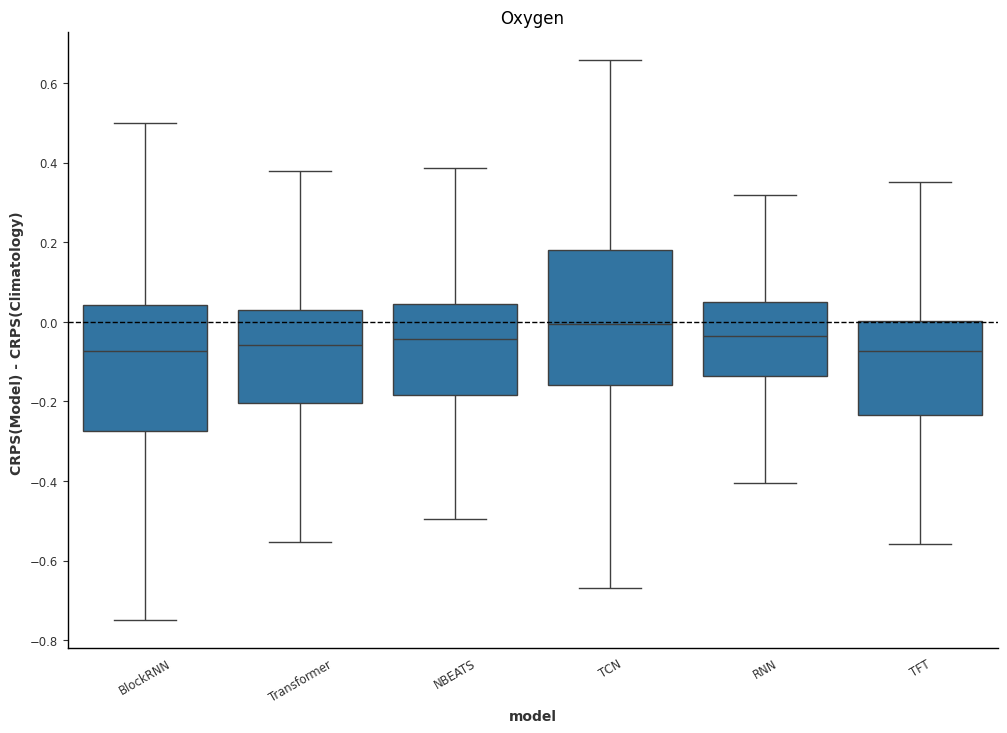

In [42]:
plot_global_percentages(best_performers_dfs['oxygen']['inter'], 'Oxygen')

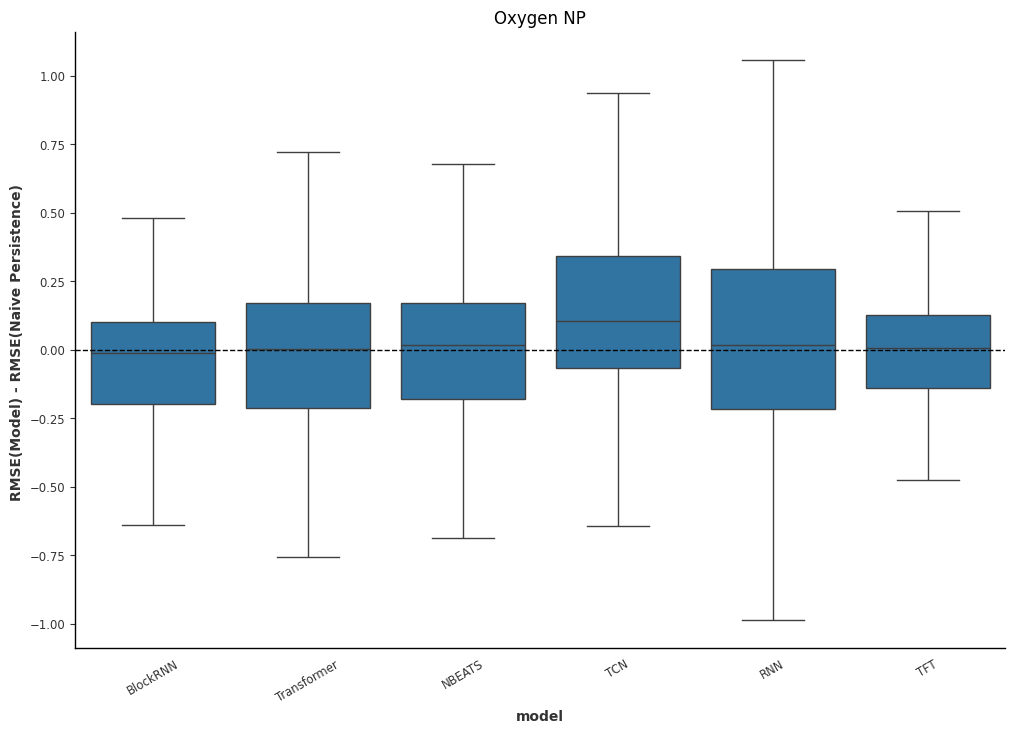

In [56]:
plot_global_percentages(best_performers_dfs['oxygen']['inter'], 'Oxygen NP', historical=False)

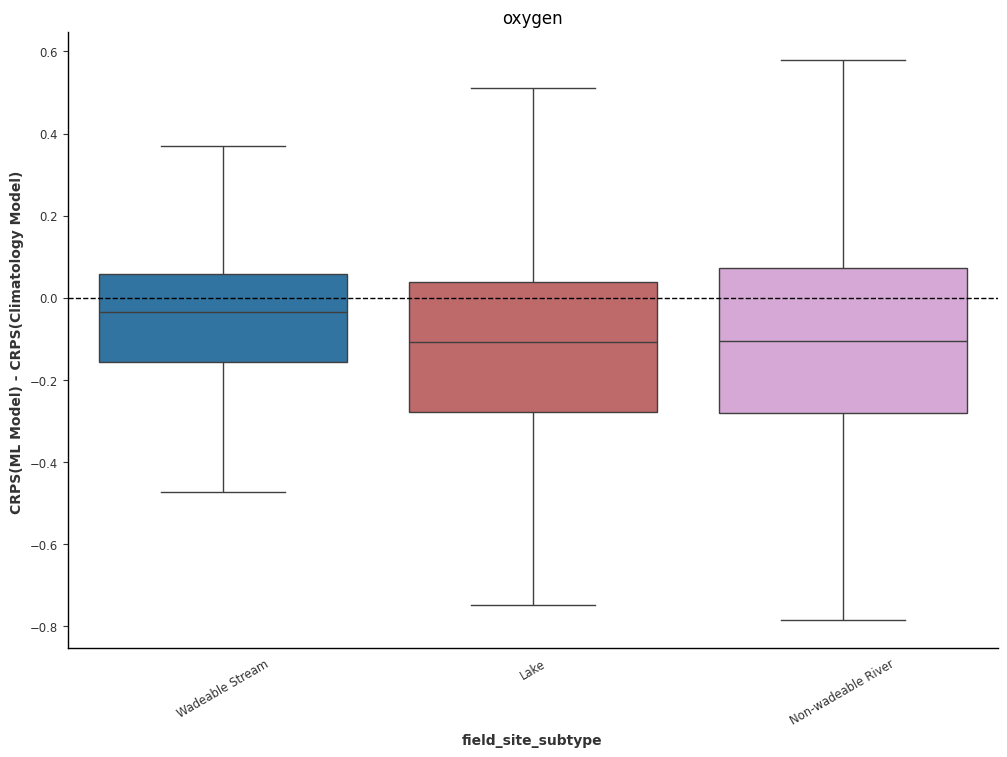

In [57]:
plot_site_type_percentages_global(
        best_performers_dfs['oxygen']['inter'], 
        metadata, 
        f'oxygen',
)

This cell is for when you have selected what models to use.

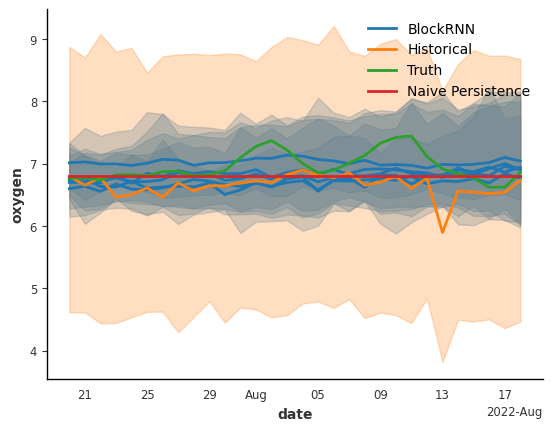

In [5]:
s3_dict = {'client': s3_client, 'bucket': 'shared-neon4cast-darts'}
plot_forecast(
    '2022_07_20', 
    targets, 
    'FLNT', 
    'oxygen', 
    'BlockRNN', 
    [0, 1, 2, 3, 4], 
    s3_dict=s3_dict,
)

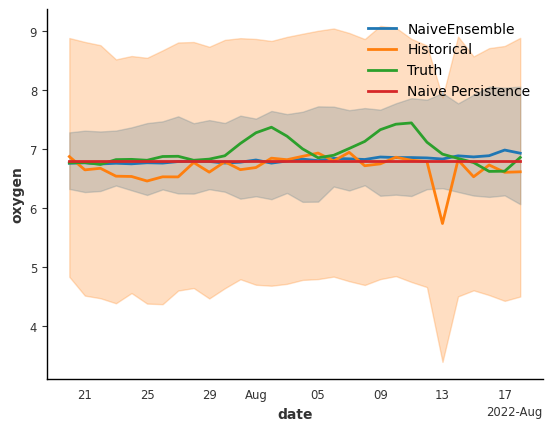

In [9]:
s3_dict = {'client': s3_client, 'bucket': 'shared-neon4cast-darts'}
plot_forecast(
    '2022_07_20', 
    targets, 
    'FLNT', 
    'oxygen', 
    'NaiveEnsemble', 
    [0], 
    s3_dict=s3_dict,
)

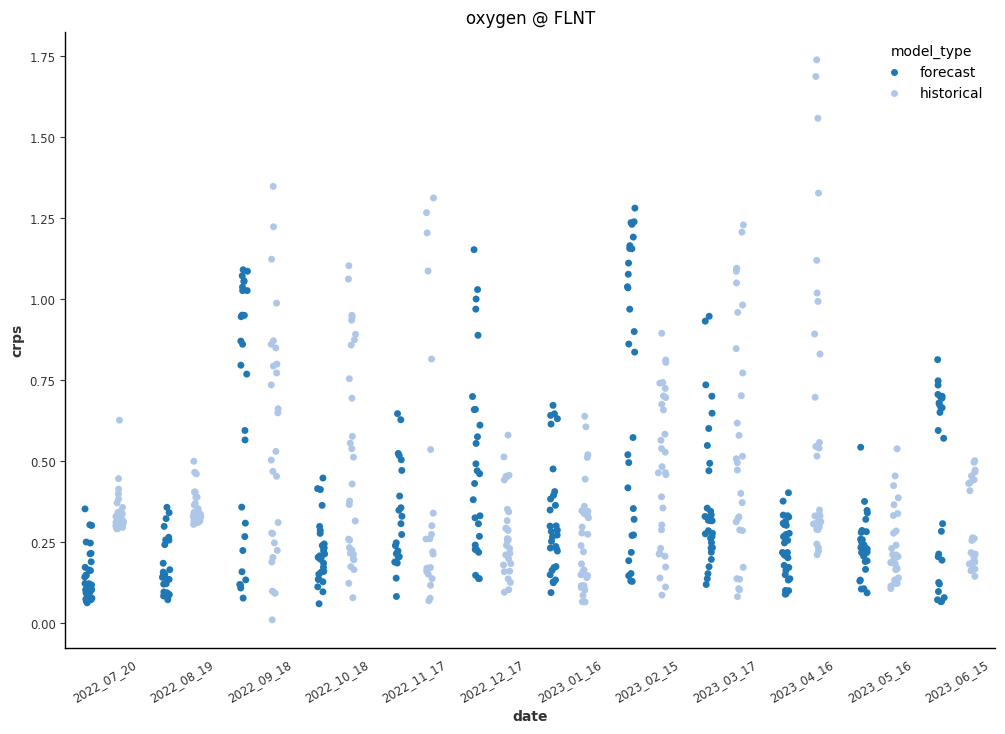

In [5]:
plot_crps_bydate('BlockRNN', 0, targets, 'FLNT', 'oxygen', s3_dict=s3_dict)

Ok now we want to work on Naive Ensembling

In [58]:
best_models

{'BlockRNN': {'oxygen': 4},
 'Transformer': {'oxygen': 0},
 'NBEATS': {'oxygen': 1},
 'TCN': {'oxygen': 4},
 'RNN': {'oxygen': 4},
 'TFT': {'oxygen': 2}}

In [60]:
best_models_listform = {}
for target_variable in target_variables:
    best_models_listform[target_variable] = [[model, best_models[model][target_variable]] for model in model_names]

In [61]:
best_models_listform['oxygen']

[['BlockRNN', 4],
 ['Transformer', 0],
 ['NBEATS', 1],
 ['TCN', 4],
 ['RNN', 4],
 ['TFT', 2]]

Need to get all the dates for which a forecast was made.

In [62]:
from s3_utils import ls_bucket

In [71]:
dates_per_site_id = best_performers_dfs['oxygen']['inter'].groupby('site_id')['date'].unique().apply(list).to_dict()

In [72]:
dates_per_site_id

{'ARIK': ['2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15',
  '2023_03_17',
  '2023_04_16',
  '2023_05_16',
  '2023_06_15'],
 'BARC': ['2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15',
  '2023_03_17',
  '2023_04_16',
  '2023_05_16',
  '2023_06_15'],
 'BIGC': ['2022_07_20',
  '2022_08_19',
  '2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15'],
 'BLDE': ['2022_07_20',
  '2022_08_19',
  '2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15',
  '2023_03_17',
  '2023_04_16',
  '2023_05_16',
  '2023_06_15'],
 'BLUE': ['2022_07_20',
  '2022_08_19',
  '2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15',
  '2023_03_17',
  '2023_04_16'],
 'BLWA': ['2022_07_20',
  '2022_08_19',
  '2022_09_18',
  '2022_10_18',
  '2022_11_17',
  '2022_12_17',
  '2023_01_16',
  '2023_02_15',
  '2023_03_17',
  '

In [74]:
from utils import NaiveEnsembleForecaster
for site in dates_per_site_id.keys():
    for date in dates_per_site_id[site]:
        ensemble_model = NaiveEnsembleForecaster(
            model_list=best_models_listform['oxygen'],
            site_id=site,
            target_variable='oxygen',
            output_name='model_0',
            date=date,
            s3_dict=s3_dict,
        )
        ensemble_model.make_forecasts()

In [75]:
model_names = ["NaiveEnsemble"]
target_variables = ["oxygen"]
ids = [0]
s3_dict = {'client': s3_client, 'bucket': 'shared-neon4cast-darts'}
scores_dict = {}
for model in model_names:
    scores_dict[model] = {}
    for id_ in ids:
        scores_dict[model][id_] = {}
        for target_variable in target_variables:
            inter_merged, intra_merged = score_improvement_bysite(
                model,
                id_,
                targets, 
                target_variable, 
                s3_dict=s3_dict,
            )
            scores_dict[model][id_][target_variable] = {}
            scores_dict[model][id_][target_variable]['inter'] = inter_merged
            scores_dict[model][id_][target_variable]['intra'] = intra_merged

Concatanate to best performers df

In [76]:
scores_dict['NaiveEnsemble'][0]['oxygen']['inter']

,site_id,date,difference_historical_ml_crps,difference_historical_ml_rmse,difference_naive_ml_rmse,difference_naive_historical_rmse,model,model_id
0,ARIK,2022_09_18,0.021626,0.245130,-0.697527,-0.942657,NaiveEnsemble,0
1,ARIK,2022_10_18,0.630575,0.892792,-2.657963,-3.550755,NaiveEnsemble,0
2,ARIK,2022_11_17,-0.281908,-0.302223,1.121285,1.423508,NaiveEnsemble,0
3,ARIK,2022_12_17,-0.633591,-0.641973,0.120523,0.762496,NaiveEnsemble,0
4,ARIK,2023_01_16,-0.234268,-0.113125,0.239242,0.352366,NaiveEnsemble,0
...,...,...,...,...,...,...,...,...
333,WLOU,2023_02_15,-0.109139,-0.111075,0.174939,0.286015,NaiveEnsemble,0
334,WLOU,2023_03_17,-0.146314,-0.156145,0.134404,0.290550,NaiveEnsemble,0
335,WLOU,2023_04_16,-0.070575,-0.067577,0.152084,0.219661,NaiveEnsemble,0
336,WLOU,2023_05_16,-0.043145,-0.123188,0.023421,0.146609,NaiveEnsemble,0


In [79]:
best_performers_dfs['oxygen']['inter']

,site_id,date,difference_historical_ml_crps,difference_historical_ml_rmse,difference_naive_ml_rmse,difference_naive_historical_rmse,model,model_id
0,ARIK,2022_09_18,0.370813,0.490371,-0.438198,-0.928569,BlockRNN,4
1,ARIK,2022_10_18,1.504866,1.494238,-2.046003,-3.540241,BlockRNN,4
2,ARIK,2022_11_17,-0.315520,-0.312066,1.134491,1.446557,BlockRNN,4
3,ARIK,2022_12_17,-0.700691,-0.853873,-0.074000,0.779873,BlockRNN,4
4,ARIK,2023_01_16,-0.356726,-0.345894,0.007859,0.353753,BlockRNN,4
...,...,...,...,...,...,...,...,...
120,GUIL,2023_02_15,-0.077783,-0.048360,-0.818046,-0.769686,TFT,2
121,GUIL,2023_03_17,-0.063629,-0.016153,0.045581,0.061735,TFT,2
122,GUIL,2023_04_16,0.044347,0.062630,0.126438,0.063808,TFT,2
123,GUIL,2023_05_16,-0.030619,-0.050913,-0.005992,0.044921,TFT,2


In [81]:
x = pd.concat([scores_dict['NaiveEnsemble'][0]['oxygen']['inter'], best_performers_dfs['oxygen']['inter']], ignore_index=True)

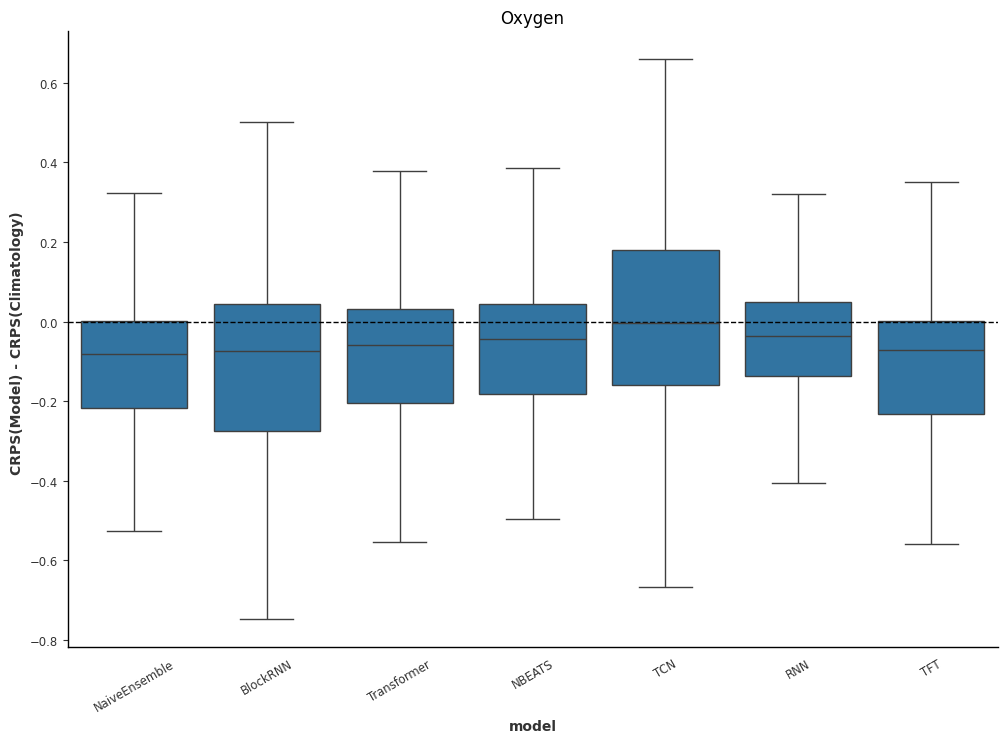

In [83]:
plot_global_percentages(x, 'Oxygen')